# Example : prediction on selected compositions

(c) Charles Le Losq and contributors, 2021-2024
see embedded licence file

In this notebook we show how one can compare i-Melt predictions with real data from the database

### Library loading and additional function definition

In [9]:
%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np

# for plotting
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec

# neuravi internals
import imelt

# other essentials
import torch

# we will work on CPU there
device = torch.device('cpu')
print(device)

cpu


### Loading dataset and models

In [10]:
# data are loaded using the data_loader helper.
ds = imelt.data_loader()

# The 10 models are loaded through a bagging class.
neuralmodel = imelt.load_pretrained_bagged()

### Viscosity prediction vizualization

Viscosity predictions can be compared to data, e.g. selecting the compositions from the database.

Let's say we want to compare the data and predictions for silica, albite-orthoclase melts, wollastonite-diopside-enstatite, and alumina melts.

First we get the good compositions.

This is easy with the names in the database, either using the publication names (Name_publi column) or using the unique Name identifier *sankmc_a_b_c_d_e_f*, with *a* the fraction of sio2, *b* that of al2o3, *c* that of na2o, d that of k2o, *e* that of mgo and *f* that of cao.

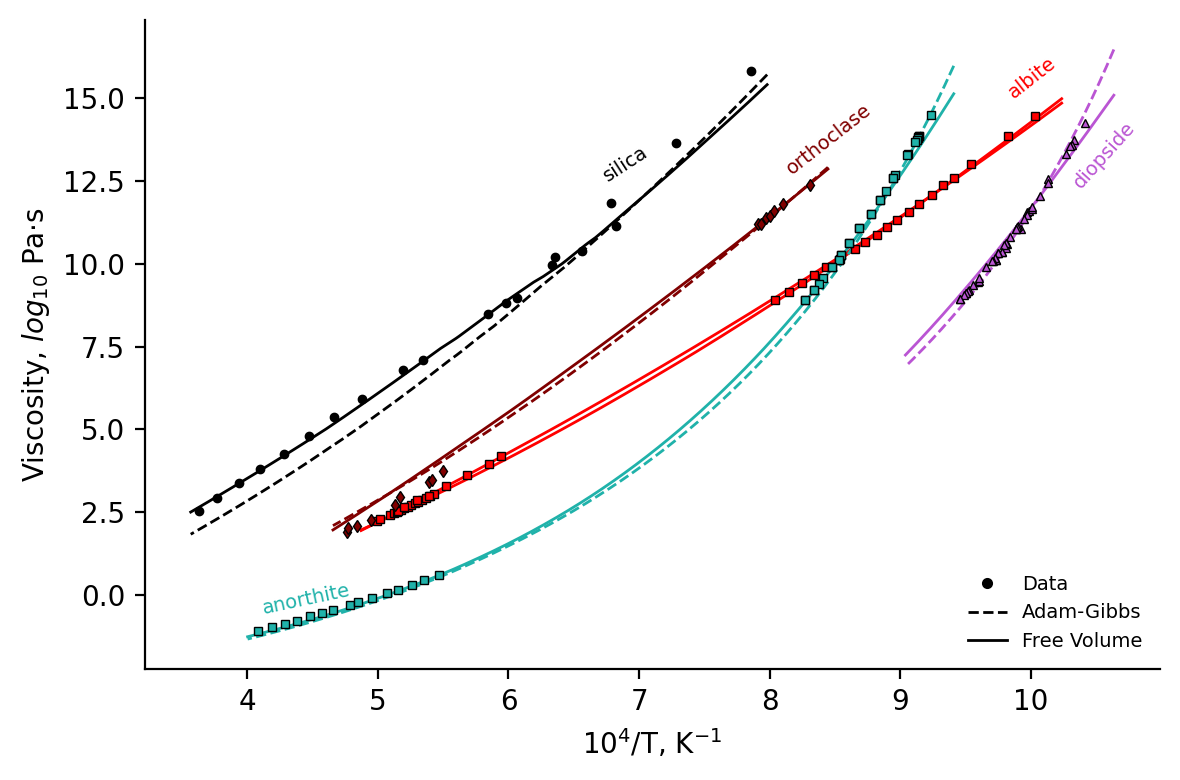

In [11]:
# we load the full viscosity database
df2 = pd.read_excel("../src/imelt/data/Database.xlsx",sheet_name="VISCO")

# we get data for silica
silica = df2.loc[df2.Name_publi=="SiO2",:].reset_index()

# for Albite, Orthoclase, and 0.5-0.5 mixture, using names from publications
Ab = df2.loc[df2.Name_publi=="NAK75_12_0",:].reset_index()
Or = df2.loc[df2.Name_publi=="NAK75_12_12",:].reset_index()

# Anorthite
An = df2.loc[df2.Name=="sankmc_50_25_0_0_0_25",:].reset_index()

# Diopside
Di = df2.loc[df2.Name=="sankmc_50_0_0_0_25_25"].reset_index()

#
# We define utility functions to do the figure below
#
def plot_viscocurve(ax,dts,method = "ag",color="k",marker="s",linestyle="-"):
    """plot viscosity predictions given some arguments"""
    x_inter = np.arange(dts.loc[:,"T"].min()-20,dts.loc[:,"T"].max()+50,1.0)

    # descriptor addition
    dts = imelt.descriptors(dts.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]/100.0)
    if dts.loc[0,"sio2"] > 1:
        ax.plot(10000/x_inter,
                 neuralmodel.predict(method,
                                     torch.Tensor(dts.loc[0,:].values.astype('float')*np.ones((len(x_inter),dts.shape[1]))/100).to(device),
                                     torch.Tensor(x_inter.reshape(-1,1)).to(device)),
                color=color, linestyle=linestyle, linewidth=1,
            )
    else:
        ax.plot(10000/x_inter,
                 neuralmodel.predict(method,
                                     torch.Tensor(dts.loc[0,:].values.astype('float')*np.ones((len(x_inter),dts.shape[1]))).to(device),
                                     torch.Tensor(x_inter.reshape(-1,1)).to(device)),
                color=color, linestyle=linestyle, linewidth=1,
            )
    return ax

### 
### FIGURE GENERATION
###

fig1 = plt.figure(figsize=(6,4),dpi=200)

gs = GridSpec(1, 1, figure=fig1)
ax = fig1.add_subplot(gs[0, 0])

# colors
colors = {'SiO2':'black',
          'albite':'red',
          'orthoclase':'maroon',
          'diopside':'mediumorchid',
          'anorthite':"lightseagreen"}

mew=0.5

# for the dummy legend
ax.plot([],[],"ko",ms=3,lw=1,label="Data")
ax.plot([],[],"k--",lw=1,label="Adam-Gibbs")
ax.plot([],[],"k-",lw=1,label="Free Volume")
ax.legend(loc="lower right", frameon=False, fontsize=7)

# data

plot_viscocurve(ax, silica, method = "cg", color=colors['SiO2'])
plot_viscocurve(ax, silica, method = "ag", linestyle="--", color=colors['SiO2'])

plot_viscocurve(ax, Ab, method = "cg", color=colors['albite'])
plot_viscocurve(ax, Ab, method = "ag", color=colors['albite'])

plot_viscocurve(ax, Or, method = "cg", color=colors['orthoclase'])
plot_viscocurve(ax, Or, method = "ag", linestyle="--", color=colors['orthoclase'])

plot_viscocurve(ax, An, method = "cg", color=colors['anorthite'])
plot_viscocurve(ax, An, method = "ag", linestyle="--", color=colors['anorthite'])

plot_viscocurve(ax, Di, method = "cg", color=colors['diopside'])
plot_viscocurve(ax, Di, method = "ag", linestyle="--", color=colors['diopside'])

markersize=3

ax.plot(10000/silica.loc[:,"T"],silica.viscosity,"o",ms=markersize,mec="k",mew=mew,color=colors['SiO2'])
ax.plot(10000/Ab.loc[:,"T"],Ab.viscosity,"s",ms=markersize,mec="black",mew=mew,color=colors['albite'])
ax.plot(10000/Or.loc[:,"T"],Or.viscosity,"d",ms=markersize,mec="black",mew=mew,color=colors['orthoclase'])
ax.plot(10000/An.loc[:,"T"],An.viscosity,"s",ms=markersize,mec="black",mew=mew,color=colors['anorthite'])
ax.plot(10000/Di.loc[:,"T"],Di.viscosity,"^",ms=markersize,mec="black",mew=mew,color=colors['diopside'])

# axes labels
ax.set_ylabel("Viscosity, $log_{10}$ Pa$\cdot$s")
ax.set_xlabel("$10^4$/T, K$^{-1}$")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#
# Annotations on plot of viscosity
#

ax.annotate("silica",xy=(6.7,12.5), xycoords="data", fontsize=7, rotation=55-22, color=colors['SiO2'])
ax.annotate("orthoclase",xy=(8.1,12.7), xycoords="data", fontsize=7, rotation=60-22, color=colors['orthoclase'])
ax.annotate("albite",xy=(9.8,15.0), xycoords="data", fontsize=7, rotation=60-22, color=colors['albite'])
ax.annotate("anorthite",xy=(4.1,-0.6), xycoords="data", fontsize=7, rotation=12, color=colors['anorthite'])
ax.annotate("diopside",xy=(10.3,12.3), xycoords="data", fontsize=7, rotation=70-22, color=colors['diopside'])

plt.tight_layout()


### We can compare systematic predictions from the 5 theories for albite glass for instance

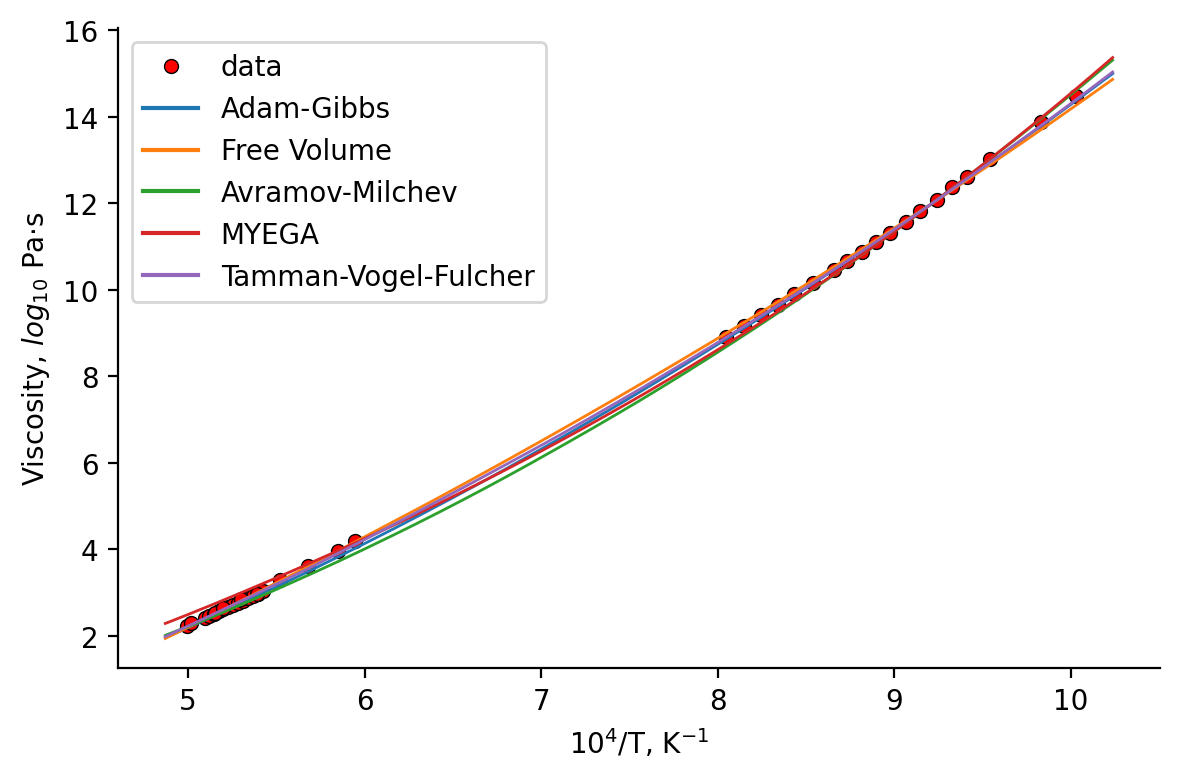

In [12]:
plt.figure(figsize=(6,4),dpi=200)
ax = plt.subplot()

# plot data
ax.plot(10000/Ab.loc[:,"T"],Ab.viscosity,".",ms=10,mec="k",mew=mew,color=colors['albite'], label="data")

correspondance_names={"ag":"Adam-Gibbs", "cg":"Free Volume", "am": "Avramov-Milchev", 
                      "myega":"MYEGA", "tvf":"Tamman-Vogel-Fulcher"}

# plot model 
for count,i in enumerate(["ag","cg","am","myega","tvf"]):
    ax.plot([],[],color="C{}".format(count),label=correspondance_names[i])
    plot_viscocurve(ax, Ab, method = i, color="C{}".format(count))
    
# axes labels
ax.set_ylabel("Viscosity, $log_{10}$ Pa$\cdot$s")
ax.set_xlabel("$10^4$/T, K$^{-1}$")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend()

plt.tight_layout()


# Raman spectra predictions

Now we do the same with Raman spectra. We construct a dictionary associating the compositions to spectra from the database.

Then we go in the train/valid datasets to get the pre-treated data corresponding to the name of the spectra.

We compare it with predictions.

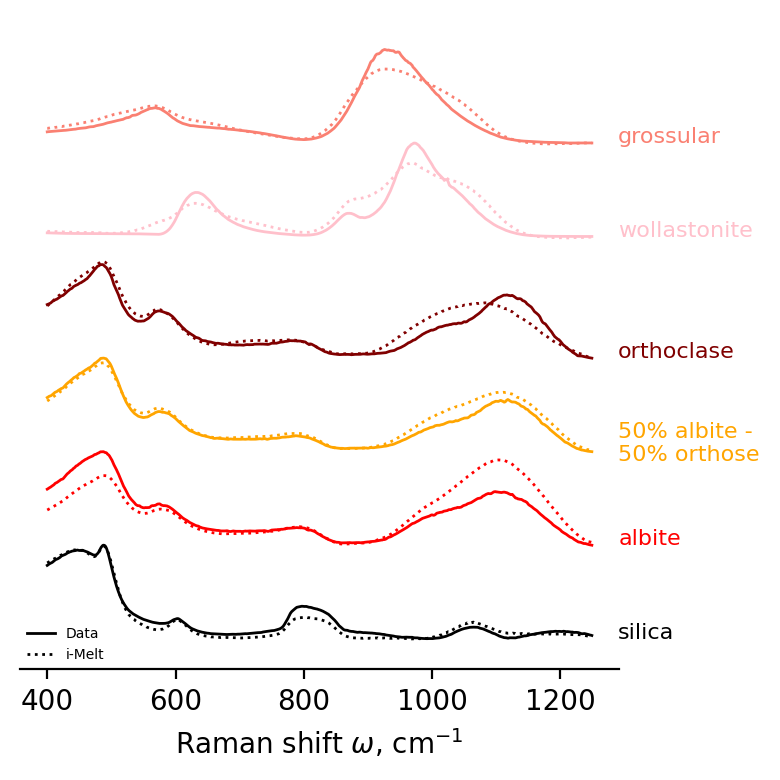

In [13]:
# we load the Raman database
df3 = pd.read_excel("../src/imelt/data/Database.xlsx",sheet_name="RAMAN")

# we associate names with specific spectra files, look at the database in Excel directly for that
spectres = {'silice':'BC029_SiO2.txt',
            'albite':'ae0836.txt',
            'orthoclase':'ae0841.txt',
            'ab-or':'ae0862.txt',
            'wollastonite':'AC1060-CA5000.txt',
            'grossulaire':'AC1038-CA4214.txt',
            }

# we associate names to specific colors
# colors
colors = {'SiO2':'black',
          'albite':'red',
          'orthoclase':'maroon',
          'AbOr':'orange',
          'wollastonite':'pink',
          'grossulaire':"salmon"}

data_compos = pd.DataFrame()
idx = 0
for i in spectres.keys():
    data_compos = pd.concat((data_compos, df3.loc[df3.nom==spectres[i]]))
    idx+=1
    
data_compos = data_compos.reset_index()

x_r_compos = torch.FloatTensor(imelt.descriptors(data_compos.loc[:,"sio2":"cao"]/100).values)
ind_compos = np.zeros((len(x_r_compos), 2))

for k in range(len(x_r_compos)) :
    
    a = x_r_compos[k] == ds.x_raman_train 
    b = x_r_compos[k] == ds.x_raman_valid
    
    for i in range(len(a)):
        if a[i].all() == True :
            ind_compos[k,0] = i
            ind_compos[k,1] = 0 #0 for train subset
    
    for i in range(len(b)):
        if b[i].all() == True :
            ind_compos[k,0] = i
            ind_compos[k,1] = 1 #1 for valid susbset
                      

y_r_compos = np.zeros((len(ind_compos), len(ds.y_raman_train[0])))

for i in range(len(ind_compos)):
    if ind_compos[i,1] == 0 :
        y_r_compos[i,:] = ds.y_raman_train[int(ind_compos[i,0])]
    if ind_compos[i,1] == 1 :
        y_r_compos[i,:] = ds.y_raman_valid[int(ind_compos[i,0])]
        
y_r_pred = np.zeros((len(ind_compos), len(ds.y_raman_train[0])))

for i in range(len(ind_compos)):   
    y_r_pred[i,:] = neuralmodel.predict("raman_pred", x_r_compos[i,:].reshape(1,-1)).ravel()
    
# Plot Raman

fig2 = plt.figure(figsize=(4,4), dpi=200)
ax2 = fig2.add_subplot(111)

ax2.plot(ds.x_raman_shift, y_r_compos[0,:],"-",color=colors["SiO2"],linewidth=1)
ax2.plot(ds.x_raman_shift, y_r_pred[0,:],":",color=colors["SiO2"],linewidth=1)

ax2.plot(ds.x_raman_shift, y_r_compos[1,:]+1,"-",color=colors["albite"],linewidth=1)
ax2.plot(ds.x_raman_shift, y_r_pred[1,:]+1,":",color=colors["albite"],linewidth=1)

ax2.plot(ds.x_raman_shift, y_r_compos[3,:]+2,"-",color=colors["AbOr"],linewidth=1)
ax2.plot(ds.x_raman_shift, y_r_pred[3,:]+2,":",color=colors["AbOr"],linewidth=1)

ax2.plot(ds.x_raman_shift, y_r_compos[2,:]+3,"-",color=colors["orthoclase"],linewidth=1)
ax2.plot(ds.x_raman_shift, y_r_pred[2,:]+3,":",color=colors["orthoclase"],linewidth=1)

ax2.plot(ds.x_raman_shift, y_r_compos[4,:]+4.3,"-",color=colors["wollastonite"],linewidth=1)
ax2.plot(ds.x_raman_shift, y_r_pred[4,:]+4.3,":",color=colors["wollastonite"],linewidth=1)

ax2.plot(ds.x_raman_shift, y_r_compos[5,:]+5.3,"-",color=colors["grossulaire"],linewidth=1)
ax2.plot(ds.x_raman_shift, y_r_pred[5,:]+5.3,":",color=colors["grossulaire"],linewidth=1)

ax2.annotate("silica",xy=(1290,0),color=colors["SiO2"],fontsize=8)
ax2.annotate("albite",xy=(1290,1),color=colors["albite"],fontsize=8)
ax2.annotate("50% albite - \n50% orthose",xy=(1290,1.9),color=colors["AbOr"],fontsize=8)
ax2.annotate("orthoclase",xy=(1290,3),color=colors["orthoclase"],fontsize=8)
ax2.annotate("wollastonite",xy=(1290,4.3),color=colors["wollastonite"],fontsize=8)
ax2.annotate("grossular",xy=(1290,5.3),color=colors["grossulaire"],fontsize=8)

# ax2.annotate("Dotted lines = model\nSolid lines = data",xy=(0.0,0.05),xycoords="axes fraction",fontsize=7)
ax2.plot([],[],'k-',lw=1,label="Data")
ax2.plot([],[],'k:',lw=1,label="i-Melt")
ax2.legend(borderpad=0,frameon=False,loc='lower left', fontsize=5)

# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_yticks([])

ax2.set_xlabel("Raman shift $\omega$, cm$^{-1}$")

plt.tight_layout()
